In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from check_shapes import check_shapes
from matplotlib.axes import Axes

import gpflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
## Solar radiance
series = pd.read_csv('../data/time_series_solar.csv', index_col="Datetime", parse_dates=True) 

In [5]:
print(series)

                     Incoming Solar
Datetime                           
2007-10-01 00:00:00             0.0
2007-10-01 01:00:00             0.0
2007-10-01 02:00:00             0.0
2007-10-01 03:00:00             0.0
2007-10-01 04:00:00             0.0
...                             ...
2013-09-30 19:00:00             0.0
2013-09-30 20:00:00             0.0
2013-09-30 21:00:00             0.0
2013-09-30 22:00:00             0.0
2013-09-30 23:00:00             0.0

[52608 rows x 1 columns]


In [6]:
# Resample the data to daily frequency
series = series.resample('D').sum()

In [7]:
series_df = series.reset_index()
plt.rcParams['figure.figsize'] = [12, 6]

In [8]:
#series_df.iloc[0:27]

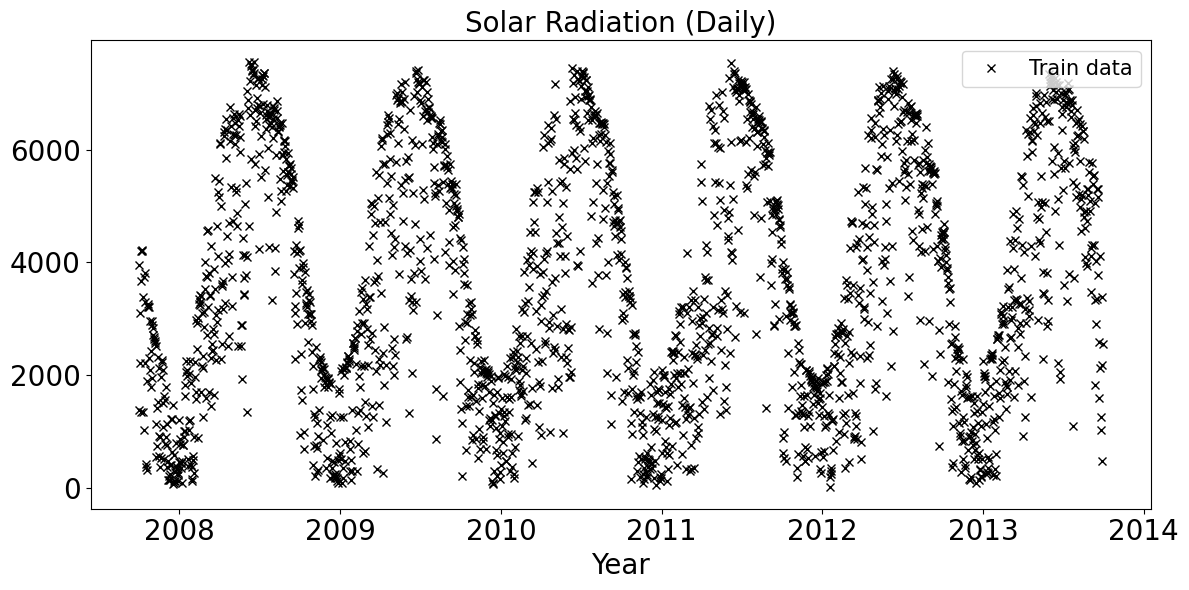

In [9]:
# Plot the data
_, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(series_df['Datetime'], series_df['Incoming Solar'], 'kx', label='Train data')

plt.legend()
plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation (Daily)', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()
#plt.xlim(1986, 2024)

plt.savefig('solar_radiation.png')
#plt.show()

### Prepare the data

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if len(data.shape) == 1 else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg


### LSTM

In [11]:
data = series_to_supervised(series, 3)
print(data)

            var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
Datetime                                            
2007-10-04     1381.5     3953.2     3098.1   2213.9
2007-10-05     3953.2     3098.1     2213.9   1338.8
2007-10-06     3098.1     2213.9     1338.8   3671.5
2007-10-07     2213.9     1338.8     3671.5   4193.7
2007-10-08     1338.8     3671.5     4193.7   4213.8
...               ...        ...        ...      ...
2013-09-26     4113.6     2134.2     1250.2   1034.2
2013-09-27     2134.2     1250.2     1034.2   2182.3
2013-09-28     1250.2     1034.2     2182.3   3384.5
2013-09-29     1034.2     2182.3     3384.5    478.2
2013-09-30     2182.3     3384.5      478.2   2554.8

[2189 rows x 4 columns]


In [12]:
# ---

scaler = MinMaxScaler(feature_range=(-1, 1))
train, test = train_test_split(data, test_size=0.2, shuffle=False)
train = scaler.fit_transform(train)
test = scaler.transform(test)

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y_test).type(torch.Tensor).view(-1)

X_train = X_train.view([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.view([X_test.shape[0], X_test.shape[1], 1])


In [13]:
time = data.index
time_train, time_test = train_test_split(time, test_size=0.2, shuffle=False)

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [15]:
model = LSTM(input_dim=1,
             hidden_dim=32,
             output_dim=1,
             num_layers=1)

In [16]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
epochs = 200

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model(X_train).reshape(-1, )
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.34706467390060425
Epoch: 10, Loss: 0.3255482316017151
Epoch: 20, Loss: 0.30702823400497437
Epoch: 30, Loss: 0.28787603974342346
Epoch: 40, Loss: 0.265292227268219
Epoch: 50, Loss: 0.2368617206811905
Epoch: 60, Loss: 0.20136022567749023
Epoch: 70, Loss: 0.16129349172115326
Epoch: 80, Loss: 0.1285974532365799
Epoch: 90, Loss: 0.1195429116487503
Epoch: 100, Loss: 0.12060604989528656
Epoch: 110, Loss: 0.11842890083789825
Epoch: 120, Loss: 0.11788389831781387
Epoch: 130, Loss: 0.1173018142580986
Epoch: 140, Loss: 0.11667009443044662
Epoch: 150, Loss: 0.11610119044780731
Epoch: 160, Loss: 0.11550435423851013
Epoch: 170, Loss: 0.11490953713655472
Epoch: 180, Loss: 0.11430706083774567
Epoch: 190, Loss: 0.11370144039392471


In [18]:
model.eval()
y_pred = model(X_test).reshape(-1, )
test_loss = loss_fn(y_pred, y_test)
print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.09931469708681107


In [19]:
# Calculate MSE
mse = mean_squared_error(y_test , y_pred.detach().numpy())
print("Mean Squared Error:", mse)

Mean Squared Error: 0.099314705


### Transform the data and the predictions to original scale

In [20]:
# Expand predictions to match original shape (N by 4), filling other columns with zeros
y_test = y_test.reshape(-1,1)

expanded_predictions = np.zeros((y_test.shape[0], 4))
expanded_predictions[:, 0] = y_pred.detach().numpy()  # Put predictions in the first column

# Apply inverse_transform
original_scale_predictions = scaler.inverse_transform(expanded_predictions)

# Extract the first column (the only relevant one)
original_scale_predictions = original_scale_predictions[:, 0]

original_scale_data_train =  scaler.inverse_transform(train)
original_scale_data_test =  scaler.inverse_transform(test)

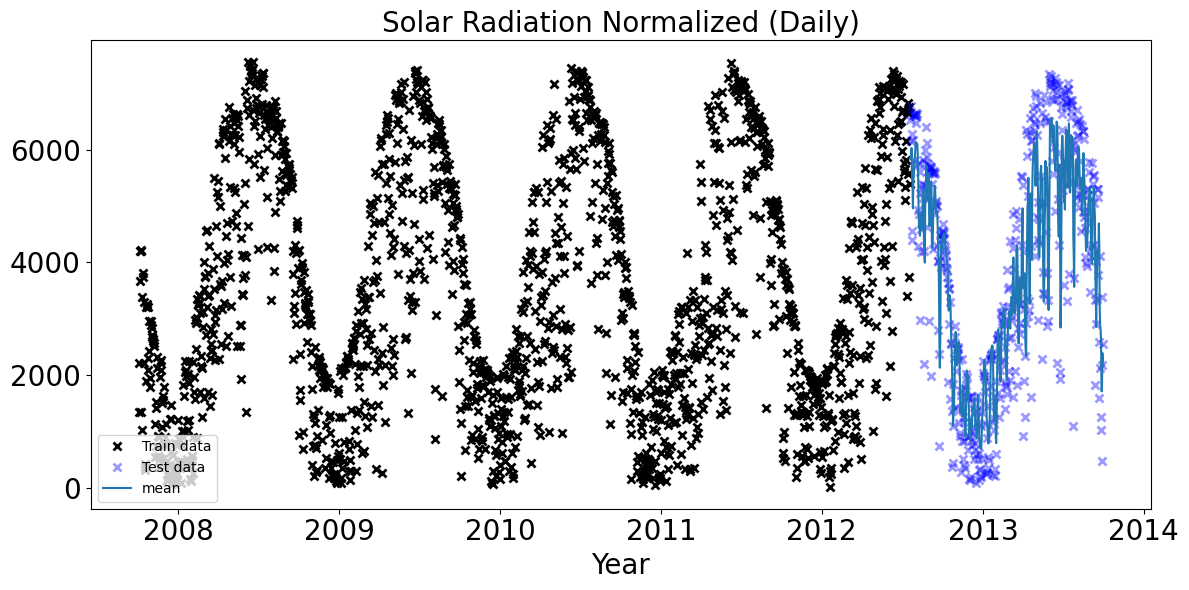

In [21]:
plt.plot(time_train, original_scale_data_train[:,3], "kx", mew=2, label="Train data")
plt.plot(time_test, original_scale_data_test[:,3], "bx", mew=2, label="Test data", alpha=0.4)

plt.plot(time_test,original_scale_predictions, "-", color="C0", label="mean")

plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation Normalized (Daily)', fontsize=20)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()

plt.savefig('solar_lstm_prediction.png')

plt.legend(loc='lower left')

In [22]:
# Calculate MSE
mse = mean_squared_error(original_scale_data_test[:,3].flatten() , original_scale_predictions.flatten())
print("Mean Squared Error:", mse/10000)

Mean Squared Error: 141.5634016598744
